<a href="https://colab.research.google.com/github/AkiraNom/News-topic-classification/blob/main/News_Topic_Classification_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Topic Classification (Fine-tuning)

This notebook demonstrates transfer learning for text classification using a pre-trained transformer model fine-tuned on a related news dataset.

- base model : `textattack/roberta-base-ag-news`
- labels: 4 categories (World, Sports, Business, Sci/Tech)
- description : This roberta-base model was fine-tuned for sequence classification using TextAttack
and the ag_news dataset loaded using the nlp library. The model was fine-tuned for 5 epochs with a batch size of 16, a learning rate of 5e-05, and a maximum sequence length of 128. Since this was a classification task, the model was trained with a cross-entropy loss function. The best score the model achieved on this task was 0.9469736842105263, as measured by the eval set accuracy, found after 4 epochs.

- repository: [hugging face repository](https://huggingface.co/textattack/roberta-base-ag-news)

Dataset for a transfoer learning:
- dataset: `SetFit/bbc-news`
- labels: 5 categories (Business, Entertainment, Politics, Sport or Tech)
- description: Dataset on BBC News Topic Classification consisting of 2,225 articles published on the BBC News website corresponding during 2004-2005.
- repository: [hugging_face_repository](https://huggingface.co/datasets/SetFit/bbc-news)


base ref: https://huggingface.co/docs/transformers/en/tasks/sequence_classification

In [1]:
!pip install datasets transformers evaluate optuna bitsandbytes peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 13.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from datasets import load_dataset
import evaluate
import optuna
from peft import (
    LoraConfig,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training
)
import torch
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    Trainer,
    TrainingArguments
)

from google.colab import drive, userdata
import wandb

In [ ]:
# set environment variables
os.environ['HF_TOKEN'] = userdata.get('HF_API_write')
os.environ["WANDB_API_KEY"] = userdata.get('WANDB_API_KEY')
os.environ["WANDB_PROJECT"]="news_classification_small"
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: anomura824 (anomura824-university-of-bern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


## Data Loading

In [ ]:
dataset_name = 'SetFit/bbc-news'
dataset = load_dataset(dataset_name)
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/880 [00:00<?, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1225
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1000
    })
})

In [ ]:
dataset['train'][:1]

{'text': ['wales want rugby league training wales could follow england s lead by training with a rugby league club.  england have already had a three-day session with leeds rhinos  and wales are thought to be interested in a similar clinic with rivals st helens. saints coach ian millward has given his approval  but if it does happen it is unlikely to be this season. saints have a week s training in portugal next week  while wales will play england in the opening six nations match on 5 february.  we have had an approach from wales   confirmed a saints spokesman.  it s in the very early stages but it is something we are giving serious consideration to.  st helens  who are proud of their welsh connections  are obvious partners for the welsh rugby union  despite a spat in 2001 over the collapse of kieron cunningham s proposed £500 000 move to union side swansea. a similar cross-code deal that took iestyn harris from leeds to cardiff in 2001 did go through  before the talented stand-off ret

## Data Inspection

## Exploratory data analysis


In [ ]:
# check number of unique labels/categories

labels = dataset['train'].unique('label')
categories = dataset['train'].unique('label_text')
print(f"length of category: {len(categories)}")
print(f"Unique category: {categories}")
print(f"length of label: {len(labels)}")
print(f"Unique label: {labels}")

# map label id to category string
id2label = {key: value for key, value in zip(labels, categories)}
print(id2label)

length of category: 5
Unique category: ['sport', 'business', 'entertainment', 'tech', 'politics']
length of label: 5
Unique label: [2, 1, 3, 0, 4]
{2: 'sport', 1: 'business', 3: 'entertainment', 0: 'tech', 4: 'politics'}


In [ ]:
df = dataset['train'].to_pandas()[['text','label', 'label_text']]
df.loc[:,'text_len'] = df['text'].apply(lambda x: len(x.split()))
df

,text,label,label_text,text_len
0,wales want rugby league training wales could f...,2,sport,248
1,china aviation seeks rescue deal scandal-hit j...,1,business,238
2,rock band u2 break ticket record u2 have smash...,3,entertainment,235
3,markets signal brazilian recovery the brazilia...,1,business,391
4,tough rules for ringtone sellers firms that fl...,0,tech,630
...,...,...,...,...
1220,us economy shows solid gdp growth the us econo...,1,business,213
1221,microsoft releases bumper patches microsoft ha...,0,tech,280
1222,stuart joins norwich from addicks norwich have...,2,sport,294
1223,why few targets are better than many the econo...,1,business,896


In [ ]:
display(df['label_text'].value_counts())

,count
label_text,
business,286
sport,275
politics,242
tech,212
entertainment,210


In [ ]:
display(df.groupby('label').describe())

text_len                                                              
         count        mean         std    min     25%    50%     75%     max
label                                                                       
0        212.0  516.896226  218.014128  165.0  356.75  469.0  646.25  1549.0
1        286.0  341.300699  145.108842  142.0  236.25  308.0  415.25   912.0
2        275.0  334.934545  170.886448  117.0  220.50  297.0  410.00  1387.0
3        210.0  337.142857  328.781859  144.0  221.00  260.0  342.50  3570.0
4        242.0  470.239669  377.855436   90.0  319.00  439.0  533.50  4492.0

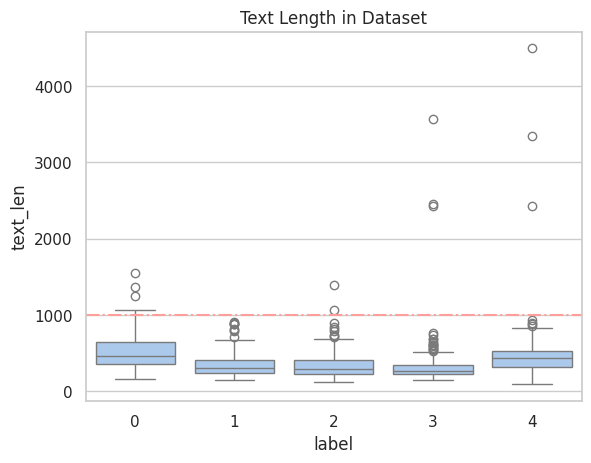

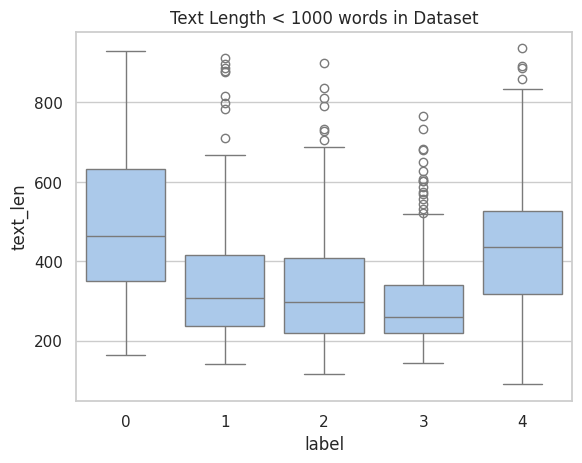

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")

MAX_TEXT_LENGTH = 1000
fig = sns.boxplot(data=df, x='label', y='text_len')
fig.set_title('Text Length in Dataset')
plt.axhline(y=MAX_TEXT_LENGTH, color='r', linestyle='-.')
plt.show()

fig = sns.boxplot(data=df[df['text_len']<MAX_TEXT_LENGTH], x='label', y='text_len')
fig.set_title(f'Text Length < {MAX_TEXT_LENGTH} words in Dataset')
plt.show()

## Preprocessing dataset


Set MAX_TEXT_LENGTH = 1000 to pre-filter overly long samples before tokenization

In [ ]:
# keep article texts and their labels
selected_features = ['text', 'label']
clean_dataset = dataset.select_columns(selected_features)
print(clean_dataset)

# remove articles longer than 1000 words
MAX_TEXT_LENGTH = 1000
clean_dataset = clean_dataset.filter(lambda x: len(x['text'].split()) < MAX_TEXT_LENGTH)
print(clean_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1225
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})


Filter:   0%|          | 0/1225 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1211
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 989
    })
})


### Tokenization

Robera-base model is used to tokenize a text.

Since the max text length in the dataset is 1_000 which is likely to exceed the maximum length accepted by the model (often 512 tokens), the longer texts are truncated to a max length specified by `max_length` argument or the max lengthy accepted by the model.

In [ ]:
checkpoint = "textattack/roberta-base-ag-news"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenization(batch):
  return tokenizer(batch["text"], truncation=True) # allows truncation for longer text

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
tokenized_dataset = clean_dataset.map(tokenization, batched=True)
tokenized_dataset

Map:   0%|          | 0/1211 [00:00<?, ? examples/s]

Map:   0%|          | 0/989 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1211
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 989
    })
})

### Save processed dataset

Once the dataset is ready, you can save it as a Hugging Face Dataset in Parquet format and reuse it later with `load_dataset()`.

In [ ]:
dataset_repo = "TetorisAce/clean_bbc_news"
tokenized_dataset.push_to_hub(dataset_repo)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########| 2.59MB / 2.59MB            

                              : 100%|##########| 2.59MB / 2.59MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########| 2.07MB / 2.07MB            

README.md:   0%|          | 0.00/523 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/TetorisAce/clean_bbc_news/commit/f89eeb0927334e7d6f6416411afc4949803b0270', commit_message='Upload dataset', commit_description='', oid='f89eeb0927334e7d6f6416411afc4949803b0270', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/TetorisAce/clean_bbc_news', endpoint='https://huggingface.co', repo_type='dataset', repo_id='TetorisAce/clean_bbc_news'), pr_revision=None, pr_num=None)

https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb

### Load Processed Dataset from Hugging Face space

In [ ]:
dataset_repo = "TetorisAce/clean_bbc_news"
tokenized_dataset = load_dataset(dataset_repo)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/523 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/2.59M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1211 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/989 [00:00<?, ? examples/s]

## Evaluation metrics

In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    preds = np.argmax(preds, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

## Setup Final Model with Quantization and Low-Rank Adapters (LoRA)

In [ ]:
# reinitialized before the new Trainer is constructed
# Accelerator().free_memory()

In [ ]:
num_labels = len(tokenized_dataset['train'].unique('label'))

id2label = {
    0: 'tech',
    1: 'business',
    2: 'sport',
    3: 'entertainment',
    4: 'politics'
    }

label2id = {v: k for k,v in id2label.items()}

### Quantization

The simplese and most straightforward way to quantize a model is to turn its weights from 32-bit floating-point (FP32) numbers into 4-bit floating-point number (NF4). This change reduces the model's memory footprint by rought a factor of eight.

There several ways to quantize a model:
- AWQ algorithm
- GPTO algorithm
- the AQLM algorithm
- the bitsandbytes library


ref:
- [Quantization](https://huggingface.co/docs/peft/en/developer_guides/quantization)
- [Fine-Tuning Your First Large Language Model (LLM) with PyTorch and Hugging Face](https://huggingface.co/blog/dvgodoy/fine-tuning-llm-hugging-face)

In [ ]:
# create quantization object
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_skip_modules=["classifier"] # read note: llm_int8_skip_modules v.
)

#### Model Size Comparison: FP32 vs 4-bit Quantized (NF4)

To assess memory efficiency, we compared the model's footprint before and after applying 4-bit quantization using `BitsAndBytesConfig`:

You can access the model's memory footprint by `model.get_memory_footprint()`

Memory Reduction: ~75%

In [ ]:
unquntized_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    ignore_mismatched_sizes=True
    )

fp32_mem = unquntized_model.get_memory_footprint()
print(f"\nFP32 Model Memory Footprint: {fp32_mem / 1e6:.2f} MB")

quantized_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    ignore_mismatched_sizes=True,
    quantization_config=quantization_config
    )

nb4_mem = quantized_model.get_memory_footprint()
print(f"\n4-bit Quantized Model Memory Footprint: {nb4_mem / 1e6:.2f} MB")

reduction = (1 - nb4_mem / fp32_mem) * 100
print('*'*50)
print(f"\n4-bit Quantized Model is {reduction:.2f}% smaller than FP32")

#### Note: `llm_int8_skip_modules`

The reason is that the last module of this model is converted to a bitsandbytes `Linear4bit` when instead of being a normal Pytorch `nn.Linear`.PEFT tries to enable gradients on it, resulting in the error

`RuntimeError: only Tensors of floating point dtype can require gradients`

This problem was reported on the [Issues - Github](https://github.com/huggingface/peft/issues/1720) and read for details.

### Setup model

There is a classic mismatch between the number of output classes in the pretrained model (4 from Ag news) and the target dataset (5 from BBC News). To reinitialize the final layer to match the number of lables in the dataset, set `ignore_mismatched_sizes=True`.

ref: [ignore_mismatched_sizes - Hugging Face](https://huggingface.co/docs/transformers/v4.41.2/main_classes/model#transformers.PreTrainedModel.from_pretrained.ignore_mismatched_sizes)

In [ ]:
checkpoint = "textattack/roberta-base-ag-news"

base_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    quantization_config=quantization_config
    )

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at textattack/roberta-base-ag-news were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at textattack/roberta-base-ag-news and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([5, 768]) in th

 ### Low-Rank Adapters (LoRA)

Low-rank adapters can be attached to each and every one of the quantized layers. The adapters are mostly regular Linear layers that can be easily updated as usual. The clever trick in this case is that these adapters are significantly smaller than the layers that have been quantized.

Since the quantized layers are frozen (they cannot be updated), setting up LoRA adapters on a quantized model drastically reduces the total number of trainable parameters to just 1% (or less) of its original size.

Set up LoRA adapters in three steps:
1. Call `prepare_model_for_kbit_training()` to improve numerical stability during training
2. Create an instance of `LoraConfig`
3. Apply the configration to the quantized base model using the `get_perft_model` method.

In [ ]:
# preprocess the quantized model for training
model = prepare_model_for_kbit_training(base_model)

# create LoRA config object
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False, # set to Fasle for training
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias='none',
    modules_to_save=["classifier"],
    )

# create a trainable PeftModel
final_model = get_peft_model(model, lora_config)

# check trainable parameters
train_p, tot_p = final_model.get_nb_trainable_parameters()
print(f'Trainable parameters:      {train_p/1e6:.2f}M')
print(f'Total parameters:          {tot_p/1e6:.2f}M')
print(f'% of trainable parameters: {100*train_p/tot_p:.2f}%')

Trainable parameters:      0.89M
Total parameters:          125.54M
% of trainable parameters: 0.71%


In [ ]:
final_model_mem = final_model.get_memory_footprint()
print(f"\nFinal Model Memory Footprint: {final_model_mem / 1e6:.2f} MB")


Final Model Memory Footprint: 204.89 MB


The extra LoRA layers inserted into the model make the model larger.

The model is ready to be fine-tuned.

## Trainer and Trainer Arguments

In [ ]:
train_dataset = tokenized_dataset["train"]
val_dataset = tokenized_dataset["test"]

In [ ]:
import datetime

date = datetime.datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
print(f"date: {date}")

date: 2025-10-07_11-00-09


In [ ]:
final_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Projects/bbc-news-topic-classifier/checkpoint/",
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="steps",
    save_steps=500,                 # Save every N steps
    save_total_limit=3,             # Optional: only keep the last 3 checkpoints to save space
    load_best_model_at_end=False, # When PEFT and quantized models with the Hugging Face Trainer, you should set load_best_model_at_end=False.
    learning_rate =4e-5,
    lr_scheduler_type = "linear",
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_strategy="steps",
    logging_steps=100,
    logging_first_step=True,
    fp16=True,
    run_name=f"topic_classifier_run_{date}",
    report_to="wandb", # W&B is active
    push_to_hub=True,
    hub_model_id="TetorisAce/bbc-news-topic-classifier",
    hub_strategy="checkpoint",
)

final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
final_trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.017500,0.405661,0.884732,0.882593
2,0.345500,0.316973,0.905966,0.905220
3,0.275600,0.297721,0.907988,0.906632


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=456, training_loss=0.4885346471217641, metrics={'train_runtime': 218.1518, 'train_samples_per_second': 16.654, 'train_steps_per_second': 2.09, 'total_flos': 963856597646208.0, 'train_loss': 0.4885346471217641, 'epoch': 3.0})

### Save adapter

In [ ]:
# Save the adapter model after training
adapter_output_dir = "/content/drive/MyDrive/Projects/bbc-news-topic-classifier/adapter/"
final_trainer.model.save_pretrained(adapter_output_dir)

adapter_repo_name = "TetorisAce/bbc-news-topic-classifier-adapter"
inference_model.push_to_hub(adapter_repo_name)

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:  23%|##2       |  543kB / 2.38MB            

CommitInfo(commit_url='https://huggingface.co/TetorisAce/bbc-news-topic-classifier-adapter/commit/9fe6593fc76095463ffdc5f84070795364b5ea72', commit_message='Upload model', commit_description='', oid='9fe6593fc76095463ffdc5f84070795364b5ea72', pr_url=None, repo_url=RepoUrl('https://huggingface.co/TetorisAce/bbc-news-topic-classifier-adapter', endpoint='https://huggingface.co', repo_type='model', repo_id='TetorisAce/bbc-news-topic-classifier-adapter'), pr_revision=None, pr_num=None)

## Inference

In [ ]:
from peft import PeftModel

### Load Model

In [ ]:
dataset_repo = "TetorisAce/clean_bbc_news"
tokenized_dataset = load_dataset(dataset_repo)

In [ ]:
num_labels = len(tokenized_dataset['train'].unique('label'))

id2label = {
    0: 'tech',
    1: 'business',
    2: 'sport',
    3: 'entertainment',
    4: 'politics'
    }

label2id = {v: k for k,v in id2label.items()}

In [ ]:
checkpoint = "textattack/roberta-base-ag-news"
# adapter_repo_name = "TetorisAce/bbc-news-topic-classifier-adapter"
local_model_path = "/content/drive/MyDrive/Projects/bbc-news-topic-classifier/adapter/"
# create quantization object
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_skip_modules=["classifier"] # read note: llm_int8_skip_modules v.
)

base_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    quantization_config=quantization_config
    )

# inference_model = PeftModel.from_pretrained(base_model, adapter_repo_name)
inference_model = PeftModel.from_pretrained(base_model, local_model_path)

config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at textattack/roberta-base-ag-news were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at textattack/roberta-base-ag-news and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([5, 768]) in th

In [ ]:
checkpoint = "textattack/roberta-base-ag-news"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenization(batch):
  return tokenizer(batch["text"], truncation=True) # allows truncation for longer text

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline('text-classification', model=inference_model, tokenizer=tokenizer)

Device set to use cpu


In [ ]:
sample_q ="Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his innocence and vowing."
pipe(sample_q)

[{'label': 'sport', 'score': 0.9823364615440369}]

## Save model

### save merged model (adapter + model + tokenizer) for deployment

In [ ]:
local_model_path = "/content/drive/MyDrive/Projects/bbc-news-topic-classifier/adapter/"
base_model_name = "textattack/roberta-base-ag-news"

inference_model = PeftModel.from_pretrained(base_model_name, local_model_path)
inference_model = inference_model.merge_and_unload()

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

merge_model_hub = "TetorisAce/bbc-news-topic-classifier-merged"
inference_model.push_to_hub(merge_model_hub)
tokenizer.push_to_hub(merge_model_hub)

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...515o1zr/model.safetensors:   1%|          | 1.08MB /  123MB            

CommitInfo(commit_url='https://huggingface.co/TetorisAce/bbc-news-topic-classifier-merged/commit/adb1f7190821752bd4747699a75b36d4422daea0', commit_message='Upload tokenizer', commit_description='', oid='adb1f7190821752bd4747699a75b36d4422daea0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/TetorisAce/bbc-news-topic-classifier-merged', endpoint='https://huggingface.co', repo_type='model', repo_id='TetorisAce/bbc-news-topic-classifier-merged'), pr_revision=None, pr_num=None)

## Deployment

In [2]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import gradio as gr

In [ ]:
# extrace samples for testing the app
sample_size = 5
sample = tokenized_dataset['test'].shuffle(seed=42).select(range(sample_size))

for idx in range(sample_size):
  if len(sample['text'][idx]) < 2000:
    print(idx, len(sample['text'][idx]), sample['label'][idx], pipe(sample['text'][idx]))

In [ ]:
class Model():
    """
    Class to perform news topic classification
    """
    def __init__(self, model_name):
      self.model_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
      self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)
      self.pipeline = pipeline("text-classification", model=self.model, tokenizer=self.tokenizer)

    def predict(self, text:str):
      "perform news topic prediction"

      if text:
        try:
          prediction = self.pipeline(text)
          return prediction[0]['label'].capitalize(), f"{prediction[0]['score']*100:.4f}%"

        except Exception as e:
          return e, e

      else:
        return 'Type your news article or select an example first...', 'Type your news article or select an example first...'

# model instance
model_name = "TetorisAce/bbc-news-topic-classifier-merged"
model = Model(model_name)

with gr.Blocks() as demo:
  title = "News Topic Classifier"
  description = (
      "This demo fine-tunes a RoBERTa-based model (`textattack/roberta-base-ag-news`) "
      "to classify BBC news articles into five categories. It showcases transfer learning in NLP—"
      "leveraging a high-performing AG News model to adapt quickly to a new domain with limited data.\n\n"
      "**Labels**: Business, Entertainment, Politics, Sport, and Tech.\n\n"
      "**Validation Loss**: 0.297721\n\n"
      "**Accuracy**: 0.907988\n\n"
      "**F1 Score**: 0.906632\n\n\n\n"
      "⚠️ **Performance Note:** This model is quantized for reduced memory usage. "
      "When running on a **CPU environment**, inference speed may be significantly slower "
      "due to limited quantization optimizations. "
      "For optimal performance, please use a **GPU** runtime."
  )

  with gr.Row():
      gr.Markdown(f"# {title}\n\n{description}")

  with gr.Row():
    with gr.Column():
      input_text = gr.TextArea(
          label="Input Text",
          placeholder="Paste or type your news article here...",
          lines=10)

      true_label = gr.Dropdown(
        label="True Label (Optional)",
        choices=["Business", "Entertainment", "Politics", "Sport", "Tech"],
        value=None,
        allow_custom_value=True,
        interactive=True,
        )

      submit_btn = gr.Button(value="Classify")

    with gr.Column():
      outputs = [gr.Text(label="Prediction"), gr.Text(label="Confidence")]

  submit_btn.click(model.predict, inputs=[input_text], outputs=outputs)

  with gr.Row():
    gr.Markdown("## Sample Data for testing")

  examples = gr.Examples(
      examples = [
          ["fiat mulls ferrari market listing ferrari could be listed on the stock market as part of an overhaul of fiat s carmaking operations  the financial times has reported.  it said fiat was set to restructure its business after reaching a $2bn (1.53bn euros; £1.05bn) settlement with gm about fiat s ownership. steps being considered include listing ferrari and bringing maserati and alfa romeo closer together  it said. despite strong sales of alfa romeo  fiat s car business is making a loss.  under the proposals - which the paper said could be announced within days - the iconic sportscar maker could be listed separately on the market. fiat owns a 56% stake in ferrari -best known for its dominant formula one motor racing team - having first bought into the business in 1969. it considered floating ferrari in 2002 but opted to sell a minority stake to italian bank mediobanca for 775m euros ($1bn). that sale valued ferrari - which owns the maserati brand - at 2.3bn euros. the price tag would change if maserati was stripped out. the financial times said fiat may transfer maserati within its wholly- owned alfa romeo division in an effort to exploit commercial synergies. such a move would help alfa romeo and maserati to share marketing  distribution and research & development costs. maserati and ferrari sell about 10 000 cars between them and both companies broke even in 2003.  fiat  italy s largest private sector employer  did not comment on the reported changes. fiat recently negotiated an end to its alliance with general motors. the us firm agreed to pay $2bn to exit an agreement under which it could have been liable to buy fiat outright. analysts said the reported restructuring was evidence of the greater flexibility which fiat now had to develop the business.",
          "Business"],
          ["jugnot  tops french actor league  actor gerard jugnot - star of the oscar-nominated film the chorus - has beaten gerard depardieu to become france s best-paid actor of 2004.  jugnot made 5.45m euros (£3.77m) last year  according to a table drawn up by france s le figaro newspaper. in the chorus (les choristes)  jugnot plays an inspiring music teacher at a school for troubled boys in 1949. despite starring in five films in 2004  depardieu made 3.35m euros (£2.31m) putting him third place in the chart.  his name [depardieu] is no longer sufficient to guarantee the success of a film   said le figaro newspaper. the chorus  which jugnot also co-produced  has drawn an audience of nearly nine million people since its release last year.  godzilla star jean reno was france s second best-paid actor in 2004  earning 3.55m euros (£2.45m) . his roles include a recent uncredited cameo in the oscar-nominated hotel rwanda. the highest-ranking woman on le figaro s list was audrey tautou in 10th place  earning 885 000 euros (£611 000). she starred in jean-pierre jeunet s a very long engagement (un long dimanche de fiancailles) and is also lined up to co-star with tom hanks in ron howard s the da vinci code. the chorus is nominated for best foreign film at sunday s oscar ceremony. on saturday  it will compete for the title of best film against fellow nominee a very long engagement in france s cesar film awards.",
          "Entertainment"],
          ["radcliffe will compete in london paula radcliffe will compete in the flora london marathon this year after deciding her schedule for 2005.  the 31-year-old won the race in 2002 on her marathon debut  defended her title 12 months later and will now seek a third title in the 17 april race.  it doesn t get any better than this for the 25th anniversary   said race director david bedford.  after announcing the greatest men s field ever we now have the greatest women s distance runner ever.  three years ago radcliffe smashed the women s world record in two hours 18 minutes 15 seconds.  the bedford star returned to london 12 months later  lowering her mixed-race world record of 2:17:18  which she set in chicago in october 2003  by one minute 53 secs. radcliffe s career took a setback when she failed to complete the olympic marathon and later dropped out of the athens 10 000m last august. but the 31-year-old bounced back to win the new york marathon in november. radcliffe  however  passed up the chance to go for the  big city  marathon grand slam. with wins in chicago  london and new york  only the boston marathon remains to be conquered but that takes place a day after london.  boston is definitely a race i want to do at some point  but london is very special to me   said radcliffe.  i don t pick races thinking about things like pressure. i pick the ones in my heart i really want to do.  i love the atmosphere  crowds and course and know it will always be a great quality race.  it is also the 25th anniversary this year which adds to the occasion.",
          "Sport"],
          ["2d metal slug offers retro fun like some drill sergeant from the past  metal slug 3 is a wake-up call to today s gamers molly-coddled with slick visuals and fancy trimmings.  with its hand-animated sprites and 2d side-scrolling  this was even considered retro when released in arcades four years ago. but a more frantic shooter you will not find at the end of your joypad this year. and yes  that includes halo 2. simply choose your grunt and wade through five 2d side-scrolling levels of the most hectic video game blasting you will ever encounter. it is also the toughest game you are likely to play  as hordes of enemies and few lives pile the pressure on.  players must battle soldiers  snowmen  zombies  giant crabs and aliens  not to mention the huge  screen-filling bosses that guard each of the five levels.  the shoot-anything-that-moves gameplay is peppered with moments of old-school genius. fans of robotic gastropods should note the title refers  instead  to the vast array of vehicles on offer in a game stuffed with bizarre hardware. tanks  jets and submarines can be commandeered  as well as cannon-toting camels  elephants and ostriches - more weaponry on offer than in an acre of iraq. doling out justice is a joy thanks to ultra responsive controls  and while this is a tough nut to crack  it is addictive enough to have you gagging for that one last go. and at a mere £20  metal slug 3 is as cheap as sliced  fried spuds  as the man says. of course  most of you will ignore this  lacking as it does the visual fireworks of modern blasters. but at a time when blockbuster titles offer only a fresh lick of paint in favour of real innovation  metal slug 3 is a fresh gasp of air from an era when the xbox was not even a twinkle in bill gates  eye.",
          "Tech"],
          ["soros group warns of kazakh close the open society institute (osi)  financed by billionaire george soros  has accused kazakhstan officials of trying to close down its local office.  a demand for unpaid taxes and fines of $600 000 (£425 000) is politically motivated  the osi claimed  adding that it paid the money in october. the organisation has found itself in trouble after being accused of helping to topple georgia s former president. it denies having any role  but offices have had to close across the region.  the osi shut its office in moscow last year and has withdrawn from uzbekistan and belarus. in the ukraine earlier this year  mr soros - who took on the bank of england in the 1990s - and won  was pelted by protestors.  this legal prosecution can be considered an attempt by the government to force soros foundation-kazakhstan to cease its activities in kazakhstan and shut its doors for kazakh citizens and organisations   the osi said.  the osi aims to promote democratic and open  market-based societies. since the break up of the soviet union in 1991  kazakhstan has been dominated by its president nursultan abish-uly nazarbayev. he has powers for life  while insulting the president and officials has been made a criminal offence. the government controls the printing presses and most radio and tv transmission facilities. it operates the country s national radio and tv networks. recent elections were criticised as flawed and the opposition claimed there was widespread vote rigging. supporters  however  say he brings much needed stability to a region where islamic militancy is on the rise. they also credit him with promoting inter-ethnic accord and pushing through harsh reforms.",
          "Politics"]
                ],
      inputs=[input_text, true_label]
  )

demo.launch()

Device set to use cpu


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4c6eb84d36706299f0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
